In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

1024


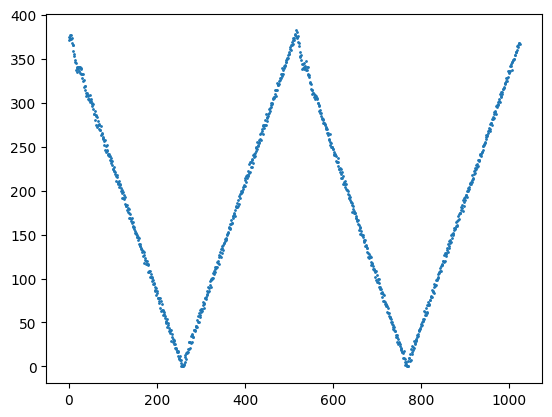

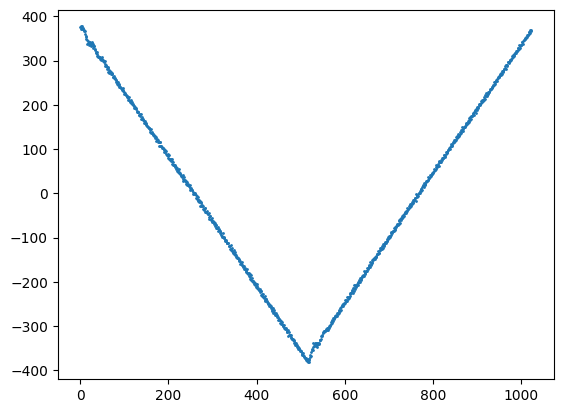

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 512
    # variables        = 2
    chi-square         = 5388.82864
    reduced chi-square = 10.5663307
    Akaike info crit   = 1209.12445
    Bayesian info crit = 1217.60110
    R-squared          = 0.99977380
[[Variables]]
    slope:     -4.8565e-05 +/- 3.2347e-08 (0.07%) (init = -5e-05)
    intercept:  0.01245760 +/- 9.5478e-06 (0.08%) (init = 0.015)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.8656
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 512
    # variables        = 2
    chi-square         = 5153.93486
    reduced chi-square = 10.1057546
    Akaike info crit   = 1186.30586
    Bayesian info crit = 1194.78251
    R-squared          = 0.99978378
[[Variables]]
    slope:      4.8578e-05 +/- 3.1634e-08 (0.07%) (init = 500000)
    intercept: -0.03733839 +/- 2.4725e-05 (0.07%) 

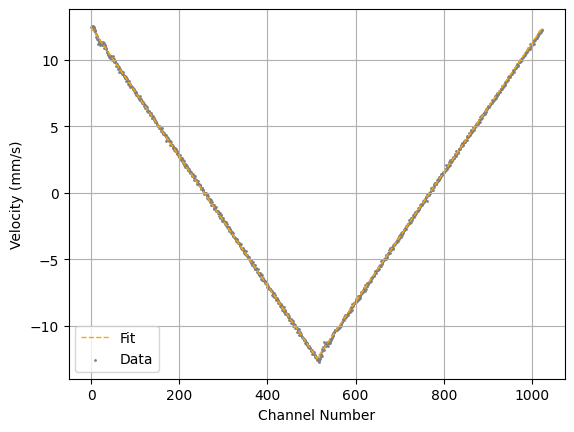

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from uncertainties import ufloat
from uncertainties.umath import sqrt
import scipy.constants as c



spectrum = np.loadtxt('data/VelocityCalibration_2025-12-15_10-03-29_10_seconds.txt', delimiter = ' ', skiprows = 0)
print(spectrum.shape[0])
plt.scatter(np.arange(spectrum.shape[0]),spectrum,s=1)
#new_spectrum = spectrum[:512] + spectrum[512:]
#plt.scatter(np.arange(spectrum.shape[0]/2),new_spectrum)

plt.show()

new2_spectrum = spectrum
new2_spectrum[int(1024/4):int(1024/4*3)] *= -1

plt.scatter(np.arange(new2_spectrum.shape[0]),new2_spectrum,s=1)
plt.show()




from lmfit.models import LinearModel
from lmfit import Minimizer, report_fit,create_params


model = LinearModel()

spectrum_left = new2_spectrum[:512]
spectrum_right = new2_spectrum[512:]
params_left = create_params(slope = -5e-5, intercept = 0.015)
params_right = create_params(slope=5e5,intercept=-0.03)
#whats the uncertainty on this? idk I think he said about one
y_uncertainty = np.ones(len(spectrum_left))
lambda_0 = 650e-9  # meters
scan_time = 10  # seconds

velocity_left = lambda_0 / (2 * scan_time) *spectrum_left *1024
velocity_right = lambda_0 / (2 * scan_time) *spectrum_right *1024
velocity_uncertainty_left = lambda_0 / (2 * scan_time) * y_uncertainty *1024
velocity_uncertainty_right = lambda_0 / (2 * scan_time) * y_uncertainty *1024






x_data_left = np.arange(spectrum_left.shape[0])
result1 = model.fit(velocity_left, params_left, x=x_data_left, weights=1/velocity_uncertainty_left)
bestfit1 = result1.best_fit
dely1 = result1.eval_uncertainty(sigma=1)



x_data_right = np.arange(spectrum_right.shape[0]) + spectrum_left.shape[0] 
result2 = model.fit(velocity_right,params_right, x= x_data_right, weights = 1/velocity_uncertainty_right)
bestfit2 = result2.best_fit
dely2 = result2.eval_uncertainty(sigma=1)


print(report_fit(result1))
print(report_fit(result2))


results = np.zeros(1024)
results[:512]= bestfit1
results[512:]= bestfit2

result_unc = np.zeros(1024)
result_unc[:512]=dely1
result_unc[512:]=dely2
x_data = np.arange(1024)
plt.plot(x_data,results*10**3,color="orange",label='Fit',linestyle='--',linewidth=1)
plt.ylabel('Velocity (mm/s)')
plt.xlabel('Channel Number')
plt.fill_between(x_data, (results - result_unc)*10**3, (results + result_unc)*10**3, color='gray', alpha=0.5)
plt.scatter(x_data, new2_spectrum * lambda_0 / (2 * scan_time) * 1024 *10**3, s=1, color='gray', label='Data')
plt.legend()
plt.grid()
plt.show()
#print(results)

data_to_save = np.column_stack((x_data, results, result_unc))
np.savetxt('fit_results.csv', data_to_save, delimiter=',', 
           header='x,y_fit,uncertainty', comments='')









# fitted parameters
m1 = result1.params['slope'].value
b1 = result1.params['intercept'].value

def v_left(x):
    return m1 * x + b1


m2 = result2.params['slope'].value
b2 = result2.params['intercept'].value

def v_right(x):
    return m2 * x + b2


def v(channel):
    if channel <= 512:
        return v_left(channel)
    if channel > 512:
        return v_right(channel)

In [3]:
#READ DATA

filename = 'data/FeSO4.txt'

with open(filename, 'r') as f:
    lines = f.readlines()

# Determine dimensions from file structure
n_rows = len(lines)
n_cols = len(lines[0].strip().split())

# Read as 2D numpy array
data_2d = np.loadtxt(filename).reshape(n_rows, n_cols)

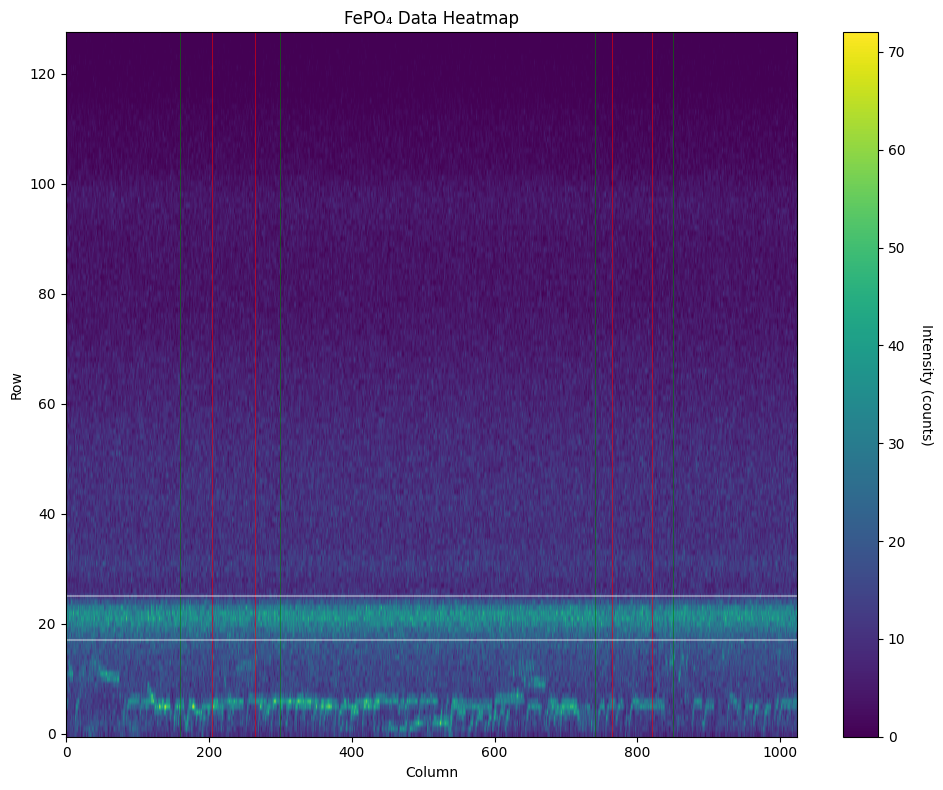

In [4]:
row_low, row_high = 17, 25   # rows you want to use

# Fit 1:
fit1_low=160
fit1_high=300

peak1_low=205
peak1_high=265

# Fit 2:
fit2_low=740
fit2_high=850

peak2_low=765
peak2_high=820



# Create heatmap
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(data_2d, cmap='viridis', aspect='auto', origin='lower')

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Intensity (counts)', rotation=270, labelpad=20)

# Labels
ax.set_xlabel('Column')
ax.set_ylabel('Row')
ax.set_title('FePO₄ Data Heatmap')

plt.tight_layout()

#peak
plt.axvline(peak1_low, color = 'red', linewidth = 0.4)
plt.axvline(peak1_high, color = 'red', linewidth = 0.4)
plt.axvline(peak2_low, color = 'red', linewidth = 0.4)
plt.axvline(peak2_high, color = 'red', linewidth = 0.4)

#fit
plt.axvline(fit1_low, color = 'green', linewidth = 0.4)
plt.axvline(fit1_high, color = 'green', linewidth = 0.4)
plt.axvline(fit2_low, color = 'green', linewidth = 0.4)
plt.axvline(fit2_high, color = 'green', linewidth = 0.4)

plt.axhline(row_low,color= "white",alpha=0.4)
plt.axhline(row_high,color= "white",alpha=0.4)
plt.show()


In [5]:
# Restrict to useful band in Y
band = data_2d[row_low:row_high+1, :]  # shape: (rows, cols)

# Sum (or average) over rows to make a 1D spectrum vs column
spectrum = band.sum(axis=0)   # or band.mean(axis=0)

channels = np.arange(band.shape[1])    # x-axis = channel index

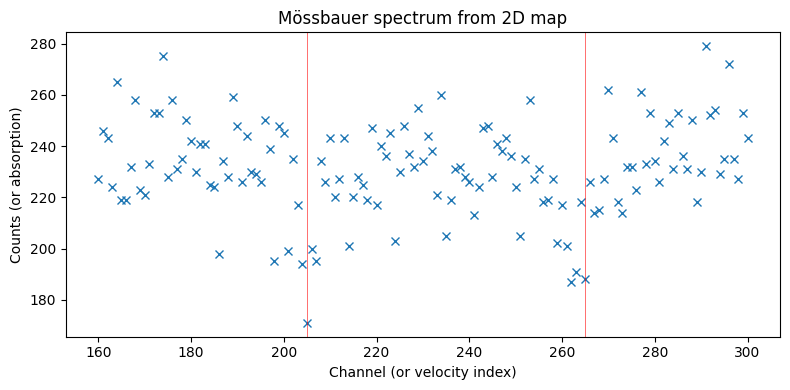

In [6]:
plt.figure(figsize=(8, 4))
plt.plot(channels[fit1_low:fit1_high+1], spectrum[fit1_low:fit1_high+1],'x')
plt.xlabel('Channel (or velocity index)')
plt.ylabel('Counts (or absorption)')
plt.title('Mössbauer spectrum from 2D map')
plt.tight_layout()
plt.axvline(peak1_low, color = 'red', linewidth = 0.4)
plt.axvline(peak1_high, color = 'red', linewidth = 0.4)
plt.show()

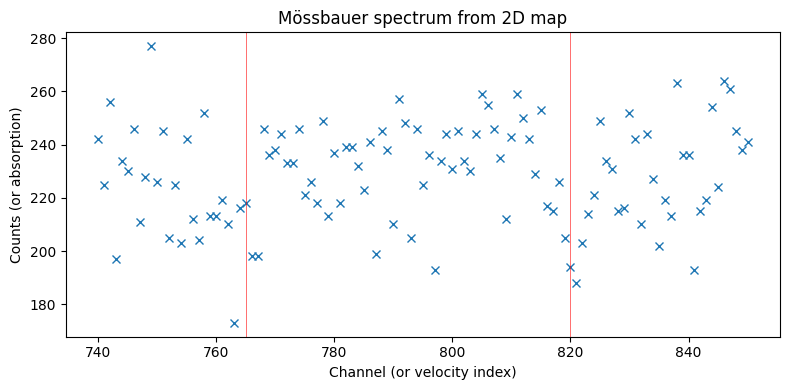

In [7]:
plt.figure(figsize=(8, 4))
plt.plot(channels[fit2_low:fit2_high+1], spectrum[fit2_low:fit2_high+1],'x')
plt.xlabel('Channel (or velocity index)')
plt.ylabel('Counts (or absorption)')
plt.title('Mössbauer spectrum from 2D map')
plt.tight_layout()
plt.axvline(peak2_low, color = 'red', linewidth = 0.4)
plt.axvline(peak2_high, color = 'red', linewidth = 0.4)

plt.show()

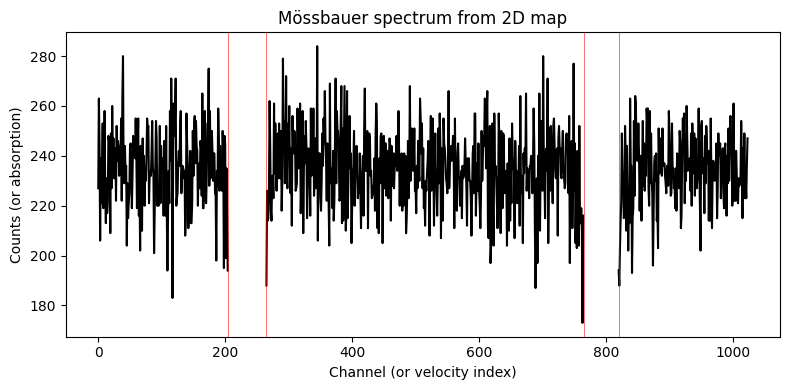

In [8]:
plt.figure(figsize=(8, 4))
plt.plot(channels[0:peak1_low], spectrum[0:peak1_low],'-k')
plt.plot(channels[peak1_high:peak2_low], spectrum[peak1_high:peak2_low],'-k')
plt.plot(channels[peak2_high:], spectrum[peak2_high:],'-k')


plt.xlabel('Channel (or velocity index)')
plt.ylabel('Counts (or absorption)')
plt.title('Mössbauer spectrum from 2D map')
plt.tight_layout()

plt.axvline(peak1_low, color = 'red', linewidth = 0.4)
plt.axvline(peak1_high, color = 'red', linewidth = 0.4)
plt.axvline(peak2_low, color = 'red', linewidth = 0.4)
plt.axvline(peak2_high, color = 'red', linewidth = 0.4)

plt.show()

Background mean: 234.5523704520397
Background sigma: 15.540173048275237


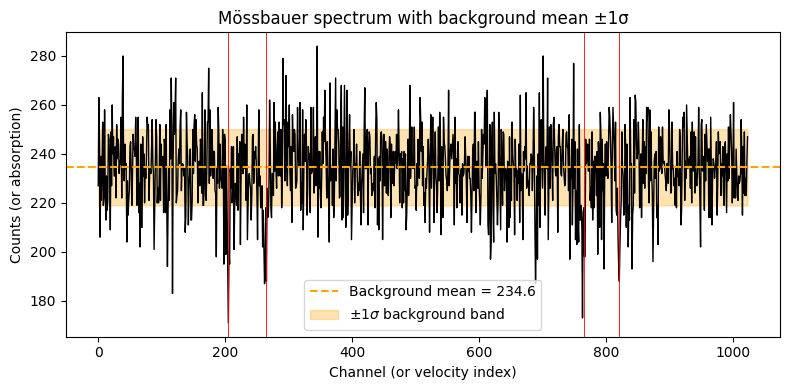

In [9]:
# Boolean mask for background channels (outside both peak regions)
bg_mask = (
    (channels < peak1_low) |
    ((channels > peak1_high) & (channels < peak2_low)) |
    (channels > peak2_high)
)

# Extract background y-values
bg_values = spectrum[bg_mask]

bg_mean = bg_values.mean()
bg_sigma = bg_values.std(ddof=1)   # sample sigma [web:35]

print("Background mean:", bg_mean)
print("Background sigma:", bg_sigma)

# Plot spectrum with background band
plt.figure(figsize=(8, 4))

# Your three background segments + peaks (optional: show full spectrum)
plt.plot(channels, spectrum, '-k', lw=1)

# Horizontal mean line
plt.axhline(bg_mean, color='orange', linestyle='--', label=f'Background mean = {bg_mean:.1f}')

# Shaded ±1σ band over the *background* x-range
x_bg = channels[bg_mask]
plt.fill_between(
    x_bg,
    bg_mean - bg_sigma,
    bg_mean + bg_sigma,
    color='orange',
    alpha=0.3,
    label=r'$\pm 1\sigma$ background band'
)  # [web:23][web:28]

# Peak markers
plt.axvline(peak1_low,  color='red', linewidth=0.6)
plt.axvline(peak1_high, color='red', linewidth=0.6)
plt.axvline(peak2_low,  color='red', linewidth=0.6)
plt.axvline(peak2_high, color='red', linewidth=0.6)

plt.xlabel('Channel (or velocity index)')
plt.ylabel('Counts (or absorption)')
plt.title('Mössbauer spectrum with background mean ±1σ')
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
from scipy.optimize import curve_fit

'''
def double_gauss_bg(x, A1, x01, sigma1, A2, x02, sigma2, m, c):
    g1 = A1 * np.exp(-(x - x01)**2 / (2 * sigma1**2))
    g2 = A2 * np.exp(-(x - x02)**2 / (2 * sigma2**2))
    bg = m * x + c
    return g1 + g2 + bg

'''

def double_gauss_bg(x, A1, x01, gamma1, A2, x02, gamma2, m, c): #loretzian
    l1 = A1 * gamma1**2 / ((x - x01)**2 + gamma1**2)
    l2 = A2 * gamma2**2 / ((x - x02)**2 + gamma2**2)
    bg = c + m * x
    return l1 + l2 + bg

In [11]:
# Fit regions
# fit1_low, fit1_high = 150, 350
# fit2_low, fit2_high = 715, 850

# Extract x,y for each window
x1 = channels[fit1_low:fit1_high+1]
y1 = spectrum[fit1_low:fit1_high+1]

x2 = channels[fit2_low:fit2_high+1]
y2 = spectrum[fit2_low:fit2_high+1]


In [12]:
# Peak windows for guidance
# peak1_low, peak1_high = 225, 275
# peak2_low, peak2_high = 750, 800

# Rough centers
x01_guess = (peak1_low + peak1_high) / 2 - 20   # left line of doublet
x02_guess = (peak1_low + peak1_high) / 2 + 20   # right line of doublet

x03_guess = (peak2_low + peak2_high) / 2 - 30
x04_guess = (peak2_low + peak2_high) / 2 + 30

# Rough amplitudes: dips below background
A1_guess = - (bg_mean - y1.min()) * 0.6
A2_guess = - (bg_mean - y1.min()) * 0.6

A3_guess = - (bg_mean - y2.min()) * 0.8
A4_guess = - (bg_mean - y2.min()) * 0.8

sigma_guess1 = 8.0   # adjust if peaks are wider/narrower
sigma_guess2 = 8.0
sigma_guess3 = 4.0
sigma_guess4 = 4.0

# Background init from edges of each window (assume nearly flat)
# def linear_bg_guess(x, y):
#     c0 = (y[0] + y[-1]) / 2
#     m0 = (y[-1] - y[0]) / (x[-1] - x[0] + 1e-9)
#     return m0, c0

m1_guess, c1_guess = [0,bg_mean]
m2_guess, c2_guess = [0,bg_mean]

In [13]:
# Fit 1
p0_1 = [A1_guess, x01_guess, sigma_guess1,
        A2_guess, x02_guess, sigma_guess2,
        m1_guess, c1_guess]

print(p0_1)

popt1, pcov1 = curve_fit(double_gauss_bg, x1, y1, p0=p0_1)  # [web:46][web:49]

# Fit 2
p0_2 = [A3_guess, x03_guess, sigma_guess3,
        A4_guess, x04_guess, sigma_guess4,
        m2_guess, c2_guess]

popt2, pcov2 = curve_fit(double_gauss_bg, x2, y2, p0=p0_2)


[np.float64(-38.13142227122382), 215.0, 8.0, np.float64(-38.13142227122382), 255.0, 8.0, 0, np.float64(234.5523704520397)]


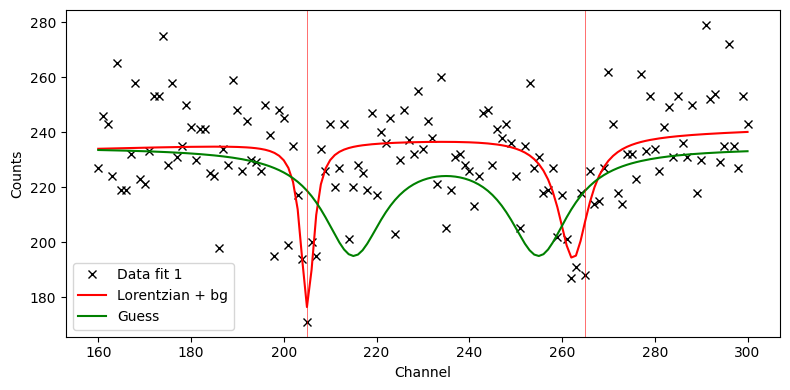

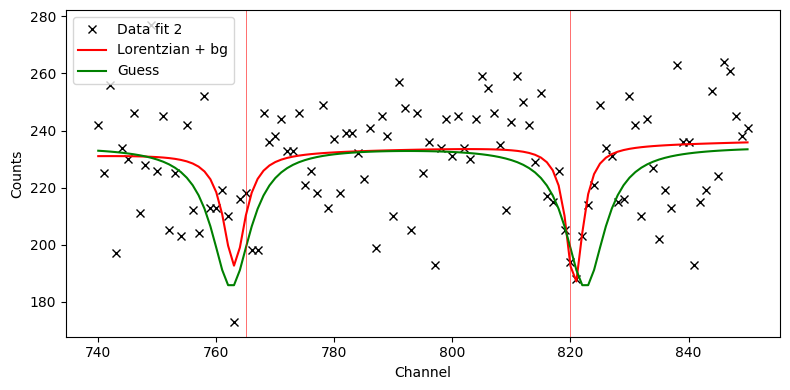

In [22]:
# Fit 1
y1_fit = double_gauss_bg(x1, *popt1)
y1_guess = double_gauss_bg(x1, *p0_1)
plt.figure(figsize=(8, 4))
plt.plot(x1, y1, 'kx', label='Data fit 1')
plt.plot(x1, y1_fit, 'r-', label='Lorentzian + bg')
plt.plot(x1, y1_guess, 'g-', label='Guess')

plt.axvline(peak1_low, color='red', linewidth=0.4)
plt.axvline(peak1_high, color='red', linewidth=0.4)
plt.xlabel('Channel')
plt.ylabel('Counts')
plt.legend()
plt.tight_layout()
plt.savefig('feso4_fit1.png')

plt.show()

# Fit 2
y2_fit = double_gauss_bg(x2, *popt2)
y2_guess = double_gauss_bg(x2, *p0_2)

plt.figure(figsize=(8, 4))
plt.plot(x2, y2, 'kx', label='Data fit 2')
plt.plot(x2, y2_fit, 'r-', label='Lorentzian + bg')
plt.plot(x2, y2_guess, 'g-', label='Guess')


plt.axvline(peak2_low, color='red', linewidth=0.4)
plt.axvline(peak2_high, color='red', linewidth=0.4)
plt.xlabel('Channel')
plt.ylabel('Counts')
plt.legend()
plt.tight_layout()
plt.savefig('feso4_fit2.png')
plt.show()


In [16]:
from uncertainties import ufloat

peak1 = v(ufloat(popt1[1], pcov1[1,1]))
print('Peak 1: ', peak1)

peak2 = v(ufloat(popt1[4], pcov1[4,4]))
print('Peak 2: ', peak2)



peak3 = v(ufloat(popt2[1], pcov2[1,1]))
print('Peak 3: ', peak3)

peak4 = v(ufloat(popt2[4], pcov2[4,4]))
print('Peak 4: ', peak4)

Peak 1:  0.002498+/-0.000007
Peak 2:  -0.000285+/-0.000029
Peak 3:  -0.000272+/-0.000027
Peak 4:  0.002529+/-0.000013


In [17]:
from uncertainties import ufloat

peak1 = (v(ufloat(popt1[1], pcov1[1,1]))+v(ufloat(popt2[4], pcov2[4,4])))/2
print('peak 1: ', peak1)

peak2 = (v(ufloat(popt1[4], pcov1[4,4]))+v(ufloat(popt2[1], pcov2[1,1])))/2
print('peak 2: ', peak2)


sigma1 = (v(ufloat(popt1[2], pcov1[2,2]))+v(ufloat(popt2[5], pcov2[5,5])))/2
print('sigma 1: ', sigma1)

sigma2 = (v(ufloat(popt1[5], pcov1[5,5]))+v(ufloat(popt2[2], pcov2[2,2])))/2
print('sigma 2: ', sigma2)





peak 1:  0.002514+/-0.000007
peak 2:  -0.000278+/-0.000020
sigma 1:  0.012375+/-0.000017
sigma 2:  0.01250+/-0.00005


In [18]:
E_0 = 14.4e3 # E in eV
c = 3e8 # c in m/s
E_1 = E_0 * (peak1 / c)
E_2 = E_0 * (peak2 / c)

print('E_1 = ', E_1, 'eV')
print('E_2 = ', E_2, 'eV')



E_1 =  (1.2066+/-0.0035)e-07 eV
E_2 =  (-1.34+/-0.09)e-08 eV


In [19]:
I = (E_1+E_2)/2
print('(isomeric shift: I = ', I, 'eV)?')

(isomeric shift: I =  (5.36+/-0.05)e-08 eV)?


In [20]:
Q = 0.21e-28
dell2_V = 2/Q*(E_1-E_2)

print('dell2_V = ', dell2_V)


dell2_V =  (1.276+/-0.010)e+22
